**MODEL DETEKSI DINI FINANCIAL DISTRESS PADA PERUSAHAAN SEKTOR
TRANSPORTASI DAN LOGISTIK DI INDONESIA MENGGUNAKAN METODE
EXPLAINABLE HISTORICAL RANDOM FOREST DAN EXTREME
GRADIENT BOOSTING**

## Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
robjects.r('install.packages("htree_2.0.0.tar.gz", repos=NULL, type="source")')
import shap
import joblib

R[write to console]: Installing package into 'C:/Users/NIMPO/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



## Load Dataset

In [233]:
data = pd.read_excel("data/Data Proyek Akhir.xlsx")
print(data.head())

      t        X1         X2        X3        X4        X5        X6  \
0  2019  0.481914  84.454211  3.475724  1.663074  0.036652  0.008808   
1  2020  0.602038  74.256820  3.917467  1.748861  0.028511  0.005821   
2  2021  1.043933  53.209918  3.808216  1.737870  0.185322  0.050511   
3  2022  0.724763  76.722323  2.585353  1.322207  0.264332  0.097017   
4  2023  0.767069  75.811490  2.286942  1.342723  0.062448  0.027277   

         X7        X8        X9         X10       X11  Y         A         B  \
0  0.167167  1.355720  1.502192  197.754750  7.233414  0  0.014648  0.600350   
1  0.109157  0.630859  1.800809   98.806683  2.799107  0  0.010180  0.642960   
2  0.184057  5.808159  1.111171   26.370679  4.874216  0  0.087782  0.526329   
3  0.226752  6.779847  1.060633    4.460852  1.175089  0  0.128277  0.514712   
4  0.135111  0.126276  0.705058    8.650307  0.538650  0  0.036625  0.413510   

          C  
0  1.492750  
1  1.436242  
2  1.786702  
3  1.505986  
4  1.607810  


## Splitting Data

In [4]:
# Data Training dengan Variabel Zmijewski
full_train_data = data[data['t'].isin([2019,2020,2021])]
full_x_train = full_train_data.drop(['Y'], axis=1)

# Data Training Bersih
train_data = data[data['t'].isin([2019,2020,2021])].drop(['A','B','C'], axis=1)
x_train = train_data.drop(['Y'], axis=1)
y_train = train_data['Y']

# Data Testing
test_data = data[data['t'].isin([2022, 2023])].drop(['A','B','C'], axis=1)
x_test = test_data.drop(['Y'], axis=1)
y_test = test_data['Y']

In [5]:
print(full_train_data.columns)

Index(['t', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'Y', 'A', 'B', 'C'],
      dtype='object')


In [6]:
print("Training Data :\n")
print(train_data.head(),"\n")
print("Testing Data :\n")
print(test_data.head(), "\n")

Training Data :

      t        X1         X2        X3        X4        X5        X6  \
0  2019  0.481914  84.454211  3.475724  1.663074  0.036652  0.008808   
1  2020  0.602038  74.256820  3.917467  1.748861  0.028511  0.005821   
2  2021  1.043933  53.209918  3.808216  1.737870  0.185322  0.050511   
5  2019  0.205249  50.181183  0.556202  0.481360  0.068464  0.039249   
6  2020  0.133491  47.418092  0.668550  0.587395  0.044393  0.021037   

         X7        X8        X9         X10       X11  Y  
0  0.167167  1.355720  1.502192  197.754750  7.233414  0  
1  0.109157  0.630859  1.800809   98.806683  2.799107  0  
2  0.184057  5.808159  1.111171   26.370679  4.874216  0  
5  0.318944  1.431556  2.623821   21.012000  1.733823  0  
6  0.260131  1.232668  2.592596   22.845614  1.383223  0   

Testing Data :

       t        X1         X2        X3        X4        X5        X6  \
3   2022  0.724763  76.722323  2.585353  1.322207  0.264332  0.097017   
4   2023  0.767069  75.811490  2

In [7]:
print(full_train_data.shape)
print(train_data.shape)
print(test_data.shape)

(66, 16)
(66, 13)
(44, 13)


## Pemeriksaan Kelas pada Data Test

In [8]:
class_counts_test = test_data['Y'].value_counts()
class_percentage_test = test_data['Y'].value_counts(normalize=True) * 100

print("Jumlah kelas pada y_test :")
print(class_counts_test)
print("\nPersentase kelas pada y_test:")
print(class_percentage_test)

Jumlah kelas pada y_test :
Y
0    34
1    10
Name: count, dtype: int64

Persentase kelas pada y_test:
Y
0    77.272727
1    22.727273
Name: proportion, dtype: float64


## Imbalance Data Checking

Jumlah kelas pada y_train :
Y
0    49
1    17
Name: count, dtype: int64

Persentase kelas pada y_train:
Y
0    74.242424
1    25.757576
Name: proportion, dtype: float64


Terdapat imbalance data


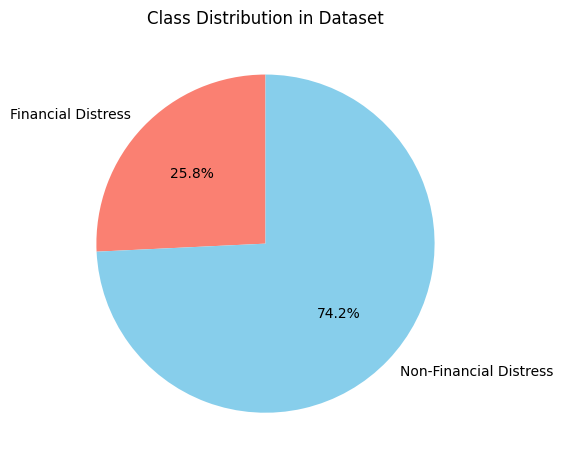

In [9]:
# Imbalance Data Checking
class_counts_train = train_data['Y'].value_counts()
class_percentage_train = train_data['Y'].value_counts(normalize=True) * 100

print("Jumlah kelas pada y_train :")
print(class_counts_train)
print("\nPersentase kelas pada y_train:")
print(class_percentage_train)

if class_counts_train[1] != class_counts_train[0]:
    print("\n\nTerdapat imbalance data")
else:
    print("\n\nData seimbang")

# Visualisasi Imbalance Data Checking
labels_check = ['Financial Distress', 'Non-Financial Distress']
sizes_check = [class_counts_train[1], class_counts_train[0]]
plt.figure(figsize=(12, 6))

# Pie Chart untuk HRF
plt.subplot(1, 2, 1)
plt.pie(sizes_check, labels=labels_check, autopct='%1.1f%%', startangle=90, colors=['salmon', 'skyblue'])
plt.title("Class Distribution in Dataset")

# Menampilkan plot
plt.show()

## Syntethic Minority Oversampling (SMOTE)

In [10]:
# Fungsi SMOTE
smote = SMOTE(random_state=123)
full_x_smote, y_smote = smote.fit_resample(full_x_train, y_train)

# Data Training dengan Variabel Zmijewski Setelah SMOTE
full_train_smote = pd.DataFrame(full_x_smote)
full_train_smote['Y'] = y_smote
full_train_smote.to_excel("train_smote.xlsx", index=False)

# Data Training Bersih Setelah SMOTE
train_smote = full_train_smote.drop(['A','B','C'], axis=1)
x_smote = train_smote.drop(['Y'], axis=1)
y_smote = train_smote['Y']

In [11]:
print(train_smote.columns)

Index(['t', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'Y'],
      dtype='object')


Jumlah kelas sebelum SMOTE :
Y
0    49
1    17
Name: count, dtype: int64

Jumlah kelas setelah SMOTE :
Y
0    49
1    49
Name: count, dtype: int64


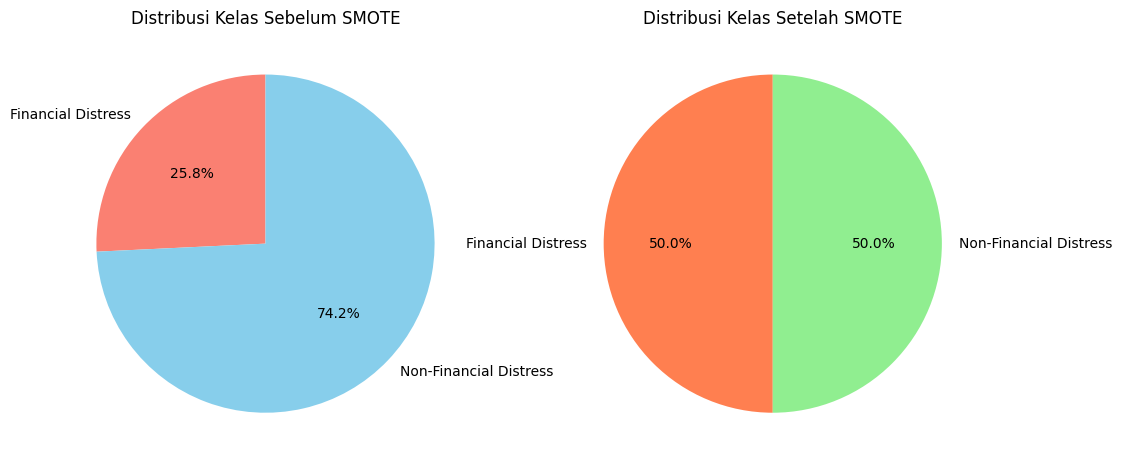

In [12]:
# Menampilkan hasil SMOTE
y_train_counts = y_train.value_counts()
y_smote_counts = pd.Series(y_smote).value_counts()
print("Jumlah kelas sebelum SMOTE :")
print(y_train_counts)

print("\nJumlah kelas setelah SMOTE :")
print(y_smote_counts)

# Visualisasi hasil SMOTE
labels_smote = ['Financial Distress', 'Non-Financial Distress']
sizes_raw = [y_train_counts[1], y_train_counts[0]]
sizes_smote = [y_smote_counts[1], y_smote_counts[0]]
plt.figure(figsize=(12, 6))

# Pie Chart sebelum SMOTE
plt.subplot(1, 2, 1)
plt.pie(sizes_raw, labels=labels_smote, autopct='%1.1f%%', startangle=90, colors=['salmon', 'skyblue'])
plt.title("Distribusi Kelas Sebelum SMOTE")

# Pie Chart setelah SMOTE
plt.subplot(1, 2, 2)
plt.pie(sizes_smote, labels=labels_smote, autopct='%1.1f%%', startangle=90, colors=['coral', 'lightgreen'])
plt.title("Distribusi Kelas Setelah SMOTE")

# Menampilkan plot
plt.show()

## t-distributed Stochastic Neighbor Embedding (T-SNE)

d:\Tugas Akhir\Tugas Akhir_Ezar Alvah Rayhan\Proyek Akhir_Ezar Alvah Rayhan\skripsi\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\Tugas Akhir\Tugas Akhir_Ezar Alvah Rayhan\Proyek Akhir_Ezar Alvah Rayhan\skripsi\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


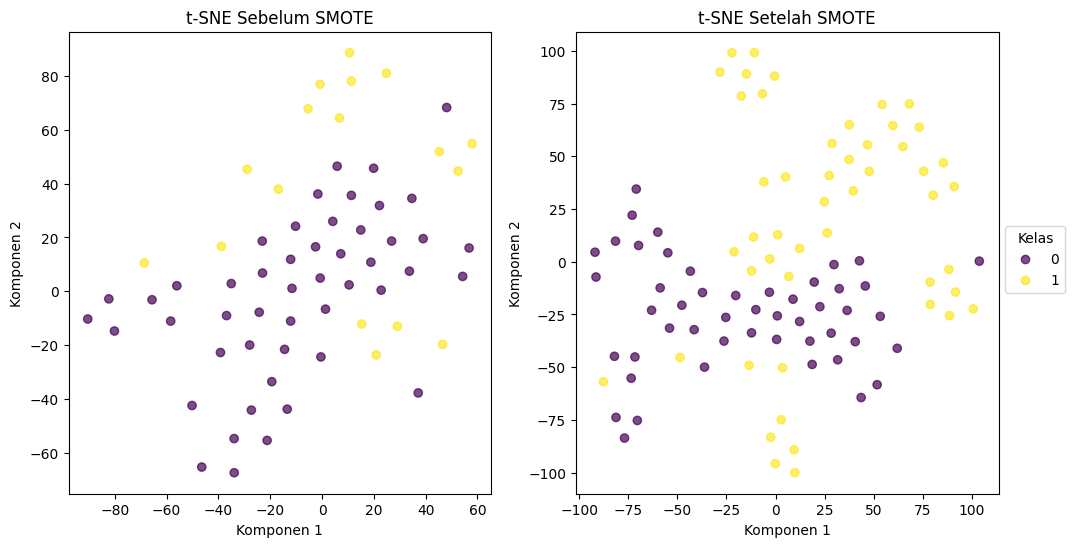

In [29]:
# Inisialisasi scaler
scaler = StandardScaler()

# Melakukan standardisasi pada data sebelum t-SNE
x_train_scaled = scaler.fit_transform((x_train).drop(['t'], axis=1))
x_smote_scaled = scaler.fit_transform((x_smote).drop(['t'], axis=1))

# TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=300, n_iter=2000, random_state=123)

# Transformasi data untuk t-SNE
x_train_tsne = tsne.fit_transform(x_train_scaled)
x_smote_tsne = tsne.fit_transform(x_smote_scaled)

# Membuat plot
plt.figure(figsize=(12, 6))

# Plot data asli
plt.subplot(1, 2, 1)
scatter_train = plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('t-SNE Sebelum SMOTE')
plt.xlabel('Komponen 1')
plt.ylabel('Komponen 2')

# Plot data setelah SMOTE
plt.subplot(1, 2, 2)
scatter_smote = plt.scatter(x_smote_tsne[:, 0], x_smote_tsne[:, 1], c=y_smote, cmap='viridis', alpha=0.7)
plt.title('t-SNE Setelah SMOTE')
plt.xlabel('Komponen 1')
plt.ylabel('Komponen 2')

# Menambahkan legend di ujung kanan dengan orientasi vertikal
plt.figlegend(*scatter_train.legend_elements(), title="Kelas", loc="center left", bbox_to_anchor=(0.9, 0.5))

# Memberi ruang di sisi kanan untuk legend
plt.show()


## Historical Random Forest

Sebelum SMOTE

Confusion Matrix:
[[33  1]
 [ 5  5]]
Accuracy: 0.8636
Sensitivity (Recall): 0.5000
Specificity: 0.9706
ROC AUC Score: 0.9853


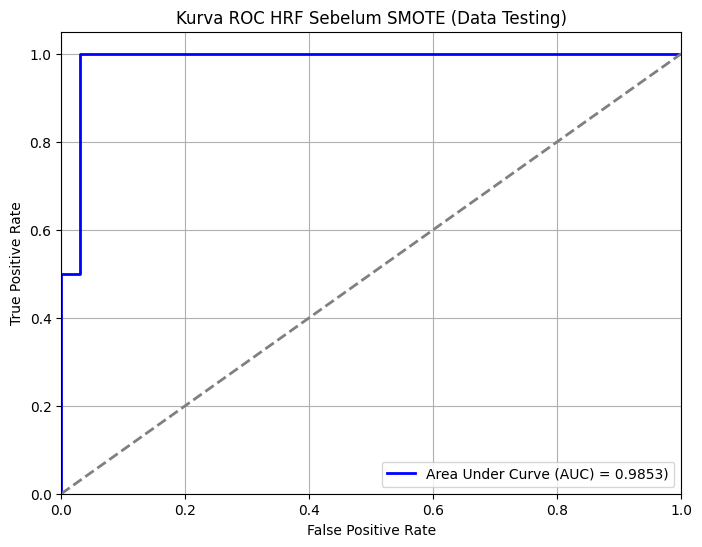

In [222]:
# Aktifkan konversi Pandas DataFrame ke R DataFrame
pandas2ri.activate()

# Impor package htree
htree = importr('htree')

# Konversi data ke R dataframe
train_data_r = pandas2ri.py2rpy(train_data)
test_data_r = pandas2ri.py2rpy(test_data)

# Mengatur nama kolom dan variabel yang benar dalam R
robjects.globalenv['train_data_r'] = train_data_r
robjects.globalenv['test_data_r'] = test_data_r
robjects.r("as.factor(train_data_r$Y)")
robjects.r("as.factor(test_data_r$Y)")

# Pastikan model dan prediksi dijalankan di R dengan seed yang sesuai
robjects.r('set.seed(123)')
np.random.seed(123)
model_hrf = robjects.r('''
htree::hrf(x=train_data_r,
          time=train_data_r$t,
          yindx=13,
          historical=TRUE,
          ntrees=1000,
          mtry=11,
          classify=TRUE,
          control=list())
''')
robjects.globalenv['model_hrf'] = model_hrf

# Prediksi probabilitas dan konversi ke DataFrame di R
prediction_prob_hrf_r = robjects.r("predict_hrf(model_hrf, x=test_data_r)")

# Ambil hasil prediksi ke Python dan konversi ke DataFrame Pandas
prediction_prob_hrf = pd.DataFrame(prediction_prob_hrf_r)

# Rename kolom menjadi Prob_0 dan Prob_1
prediction_prob_hrf.columns = ['Prob_0', 'Prob_1']

# Menambahkan label Y pada prediksi
prediction_prob_hrf['Y'] = np.where(prediction_prob_hrf['Prob_0'] > prediction_prob_hrf['Prob_1'], 0, 1)

# Hitung Confusion Matrix
cm_hrf = confusion_matrix(y_test, prediction_prob_hrf['Y'])

# Hitung akurasi, sensitivitas, dan spesifisitas
accuracy_hrf = accuracy_score(y_test, prediction_prob_hrf['Y'])
sensitivity_hrf = recall_score(y_test, prediction_prob_hrf['Y'])
specificity_hrf = cm_hrf[0, 0] / (cm_hrf[0, 0] + cm_hrf[0, 1])

print("Confusion Matrix:")
print(cm_hrf)
print(f"Accuracy: {accuracy_hrf:.4f}")
print(f"Sensitivity (Recall): {sensitivity_hrf:.4f}")
print(f"Specificity: {specificity_hrf:.4f}")

# Hitung ROC AUC Score
roc_auc_hrf = roc_auc_score(y_test, prediction_prob_hrf['Prob_1'])
print(f"ROC AUC Score: {roc_auc_hrf:.4f}")

# Plot ROC curve
fpr_hrf, tpr_hrf, thresholds_hrf = roc_curve(y_test, prediction_prob_hrf['Prob_1'])

plt.figure(figsize=(8, 6))
plt.plot(fpr_hrf, tpr_hrf, color='blue', lw=2, label='Area Under Curve (AUC) = {:.4f})'.format(roc_auc_hrf))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC HRF Sebelum SMOTE (Data Testing)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix:
[[49  0]
 [ 0 17]]
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
ROC AUC Score: 1.0000


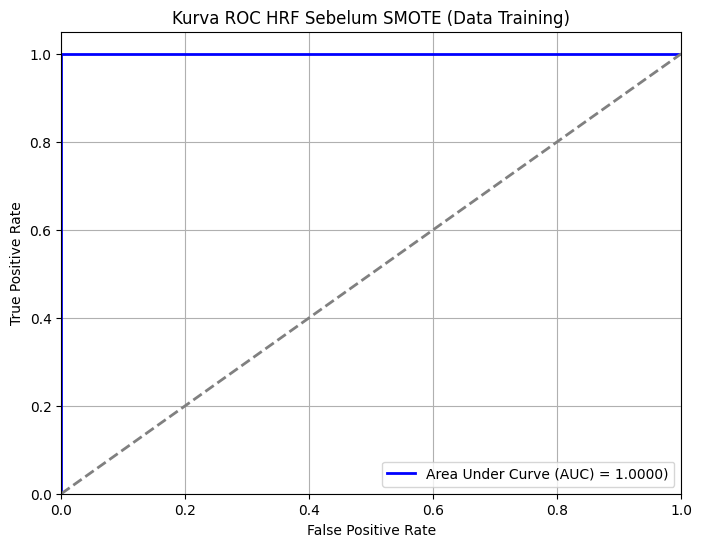

In [223]:
# Prediksi probabilitas dan konversi ke DataFrame di R
prediction_prob_hrf_train_r = robjects.r("predict_hrf(model_hrf, x=train_data_r)")

# Ambil hasil prediksi ke Python dan konversi ke DataFrame Pandas
prediction_prob_hrf_train = pd.DataFrame(prediction_prob_hrf_train_r)

# Rename kolom menjadi Prob_0 dan Prob_1
prediction_prob_hrf_train.columns = ['Prob_0', 'Prob_1']

# Menambahkan label Y pada prediksi
prediction_prob_hrf_train['Y'] = np.where(prediction_prob_hrf_train['Prob_0'] > prediction_prob_hrf_train['Prob_1'], 0, 1)

# Hitung Confusion Matrix
cm_hrf_train = confusion_matrix(y_train, prediction_prob_hrf_train['Y'])

# Hitung akurasi, sensitivitas, dan spesifisitas
accuracy_hrf_train = accuracy_score(y_train, prediction_prob_hrf_train['Y'])
sensitivity_hrf_train = recall_score(y_train, prediction_prob_hrf_train['Y'])
specificity_hrf_train = cm_hrf_train[0, 0] / (cm_hrf_train[0, 0] + cm_hrf_train[0, 1])

print("Confusion Matrix:")
print(cm_hrf_train)
print(f"Accuracy: {accuracy_hrf_train:.4f}")
print(f"Sensitivity (Recall): {sensitivity_hrf_train:.4f}")
print(f"Specificity: {specificity_hrf_train:.4f}")

# Hitung ROC AUC Score
roc_auc_hrf_train = roc_auc_score(y_train, prediction_prob_hrf_train['Prob_1'])
print(f"ROC AUC Score: {roc_auc_hrf_train:.4f}")

# Plot ROC curve
fpr_hrf_train, tpr_hrf_train, thresholds_hrf_train = roc_curve(y_train, prediction_prob_hrf_train['Prob_1'])

plt.figure(figsize=(8, 6))
plt.plot(fpr_hrf_train, tpr_hrf_train, color='blue', lw=2, label='Area Under Curve (AUC) = {:.4f})'.format(roc_auc_hrf_train))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC HRF Sebelum SMOTE (Data Training)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Setelah SMOTE


Confusion Matrix:
[[33  1]
 [ 0 10]]
Accuracy: 0.9773
Sensitivity (Recall): 1.0000
Specificity: 0.9706
ROC AUC Score: 1.0000


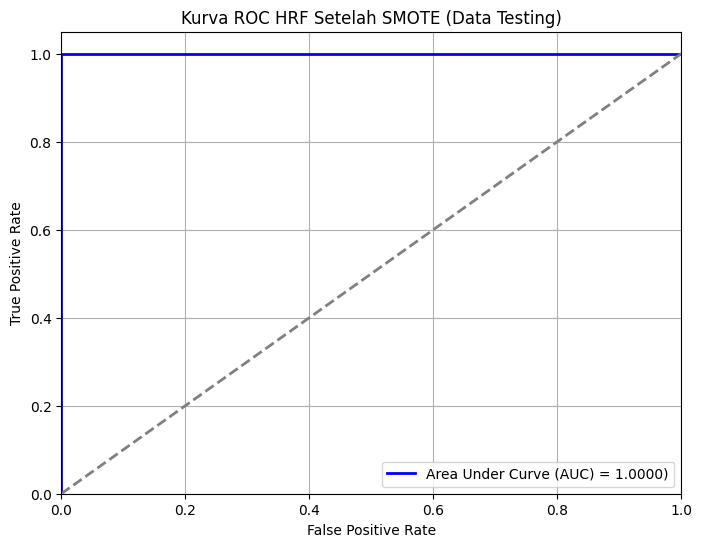

In [226]:
# Aktifkan konversi Pandas DataFrame ke R DataFrame
pandas2ri.activate()

# Impor package htree
htree = importr('htree')

# Konversi data ke R dataframe
train_smote_r = pandas2ri.py2rpy(train_smote)
test_data_r = pandas2ri.py2rpy(test_data)

# Mengatur nama kolom dan variabel yang benar dalam R
robjects.globalenv['train_smote_r'] = train_smote_r
robjects.globalenv['test_data_r'] = test_data_r
robjects.r("as.factor(train_smote_r$Y)")
robjects.r("as.factor(test_data_r$Y)")

# Pastikan model dan prediksi dijalankan di R dengan seed yang sesuai
robjects.r('set.seed(123)')
np.random.seed(123)
model_smote_hrf = robjects.r('''
htree::hrf(x=train_smote_r,
          time=train_smote_r$t,
          yindx=13,
          historical=TRUE,
          ntrees=1000,
          mtry=15,
          classify=TRUE,
          control=list())
''')
robjects.globalenv['model_smote_hrf'] = model_smote_hrf

# Prediksi probabilitas dan konversi ke DataFrame di R
prediction_prob_smote_hrf_r = robjects.r("predict_hrf(model_smote_hrf, x=test_data_r)")

# Ambil hasil prediksi ke Python dan konversi ke DataFrame Pandas
prediction_prob_smote_hrf = pd.DataFrame(prediction_prob_smote_hrf_r)

# Rename kolom menjadi Prob_0 dan Prob_1
prediction_prob_smote_hrf.columns = ['Prob_0', 'Prob_1']

# Menambahkan label Y pada prediksi
prediction_prob_smote_hrf['Y'] = np.where(prediction_prob_smote_hrf['Prob_0'] > prediction_prob_smote_hrf['Prob_1'], 0, 1)

# Hitung Confusion Matrix
cm_smote_hrf = confusion_matrix(y_test, prediction_prob_smote_hrf['Y'])

# Hitung akurasi, sensitivitas, dan spesifisitas
accuracy_smote_hrf = accuracy_score(y_test, prediction_prob_smote_hrf['Y'])
sensitivity_smote_hrf = recall_score(y_test, prediction_prob_smote_hrf['Y'])
specificity_smote_hrf = cm_smote_hrf[0, 0] / (cm_smote_hrf[0, 0] + cm_smote_hrf[0, 1])

print("Confusion Matrix:")
print(cm_smote_hrf)
print(f"Accuracy: {accuracy_smote_hrf:.4f}")
print(f"Sensitivity (Recall): {sensitivity_smote_hrf:.4f}")
print(f"Specificity: {specificity_smote_hrf:.4f}")

# Hitung ROC AUC Score
roc_auc_smote_hrf = roc_auc_score(y_test, prediction_prob_smote_hrf['Prob_1'])
print(f"ROC AUC Score: {roc_auc_smote_hrf:.4f}")

# Plot ROC curve
fpr_smote_hrf, tpr_smote_hrf, thresholds_smote_hrf = roc_curve(y_test, prediction_prob_smote_hrf['Prob_1'])

plt.figure(figsize=(8, 6))
plt.plot(fpr_smote_hrf, tpr_smote_hrf, color='blue', lw=2, label='Area Under Curve (AUC) = {:.4f})'.format(roc_auc_smote_hrf))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC HRF Setelah SMOTE (Data Testing)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix:
[[49  0]
 [ 0 17]]
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
ROC AUC Score: 1.0000


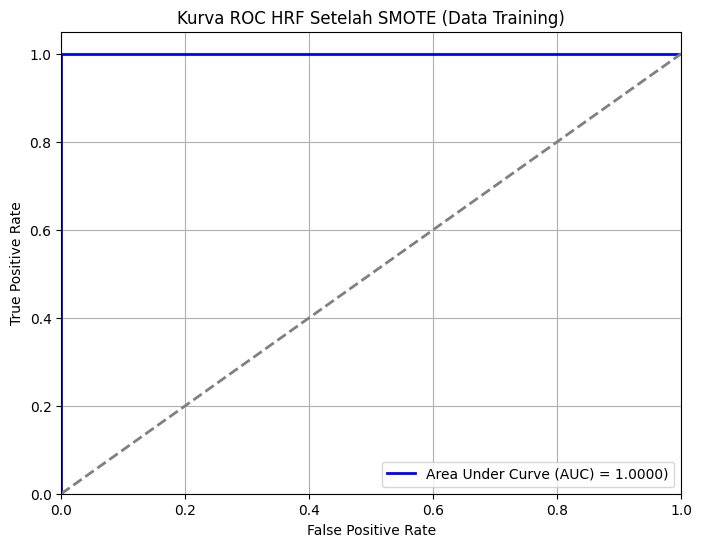

In [227]:
# Prediksi probabilitas dan konversi ke DataFrame di R
prediction_prob_smote_hrf_train_r = robjects.r("predict_hrf(model_smote_hrf, x=train_data_r)")

# Ambil hasil prediksi ke Python dan konversi ke DataFrame Pandas
prediction_prob_smote_hrf_train = pd.DataFrame(prediction_prob_smote_hrf_train_r)

# Rename kolom menjadi Prob_0 dan Prob_1
prediction_prob_smote_hrf_train.columns = ['Prob_0', 'Prob_1']

# Menambahkan label Y pada prediksi
prediction_prob_smote_hrf_train['Y'] = np.where(prediction_prob_smote_hrf_train['Prob_0'] > prediction_prob_smote_hrf_train['Prob_1'], 0, 1)

# Hitung Confusion Matrix
cm_smote_hrf_train = confusion_matrix(y_train, prediction_prob_smote_hrf_train['Y'])

# Hitung akurasi, sensitivitas, dan spesifisitas
accuracy_smote_hrf_train = accuracy_score(y_train, prediction_prob_smote_hrf_train['Y'])
sensitivity_smote_hrf_train = recall_score(y_train, prediction_prob_smote_hrf_train['Y'])
specificity_smote_hrf_train = cm_smote_hrf_train[0, 0] / (cm_smote_hrf_train[0, 0] + cm_smote_hrf_train[0, 1])

print("Confusion Matrix:")
print(cm_smote_hrf_train)
print(f"Accuracy: {accuracy_smote_hrf_train:.4f}")
print(f"Sensitivity (Recall): {sensitivity_smote_hrf_train:.4f}")
print(f"Specificity: {specificity_smote_hrf_train:.4f}")

# Hitung ROC AUC Score
roc_auc_smote_hrf_train = roc_auc_score(y_train, prediction_prob_smote_hrf_train['Prob_1'])
print(f"ROC AUC Score: {roc_auc_smote_hrf_train:.4f}")

# Plot ROC curve
fpr_smote_hrf_train, tpr_smote_hrf_train, thresholds_smote_hrf_train = roc_curve(y_train, prediction_prob_smote_hrf_train['Prob_1'])

plt.figure(figsize=(8, 6))
plt.plot(fpr_smote_hrf_train, tpr_smote_hrf_train, color='blue', lw=2, label='Area Under Curve (AUC) = {:.4f})'.format(roc_auc_smote_hrf_train))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC HRF Setelah SMOTE (Data Training)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Extreme Gradient Boosting

In [212]:
# Set Dataset XGB
x_train_xgb = x_train.drop(['t'], axis=1)
x_test_xgb = x_test.drop(['t'], axis=1)
x_smote_xgb = x_smote.drop(['t'], axis=1)

Sebelum SMOTE

Confusion Matrix XGBoost:
Confusion Matrix:
[[33  1]
 [ 1  9]]
Accuracy: 0.9545
Sensitivity (Recall): 0.9000
Specificity: 0.9706
ROC AUC Score XGBoost: 0.9971


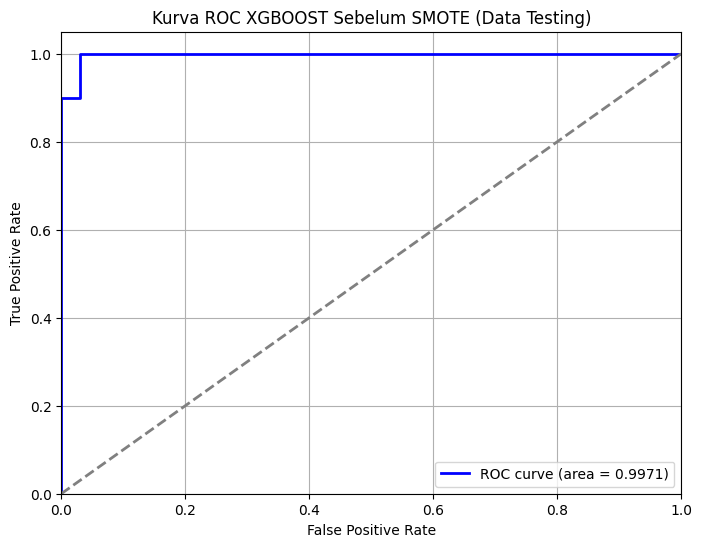

In [213]:
# Melatih model XGBoost dengan data SMOTE
xgb_model = XGBClassifier(random_state=123)
xgb_model.fit(x_train_xgb, y_train)

# Melakukan prediksi
y_pred_xgb = xgb_model.predict(x_test_xgb)

# Evaluasi model XGBoost
print("Confusion Matrix XGBoost:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
sensitivity_xgb = recall_score(y_test, y_pred_xgb)
specificity_xgb = cm_xgb[0, 0] / (cm_xgb[0, 0] + cm_xgb[0, 1])

print("Confusion Matrix:")
print(cm_xgb)
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Sensitivity (Recall): {sensitivity_xgb:.4f}")
print(f"Specificity: {specificity_xgb:.4f}")
# Hitung ROC AUC Score XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(x_test_xgb)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC AUC Score XGBoost: {:.4f}".format(roc_auc_xgb))

# Plot ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC XGBOOST Sebelum SMOTE (Data Testing)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix XGBoost:
Confusion Matrix:
[[49  0]
 [ 0 17]]
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
ROC AUC Score XGBoost: 1.0000


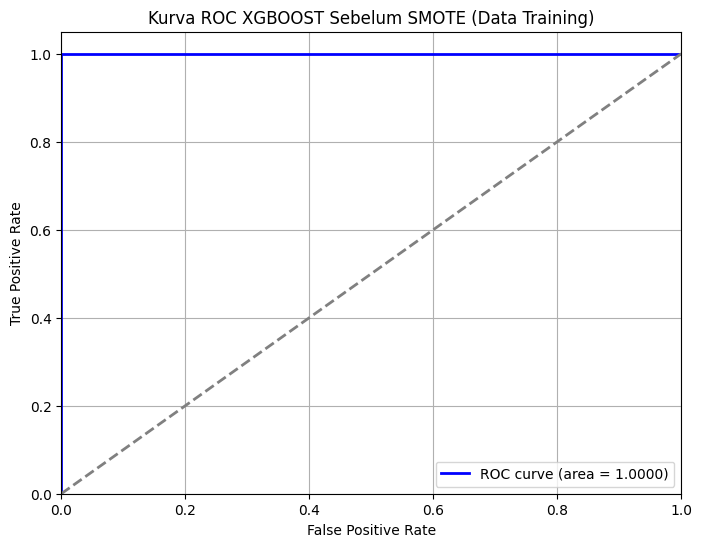

In [214]:
# Melakukan prediksi
y_pred_xgb_train = xgb_model.predict(x_train_xgb)

# Evaluasi model XGBoost
print("Confusion Matrix XGBoost:")
cm_xgb_train = confusion_matrix(y_train, y_pred_xgb_train)

accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
sensitivity_xgb_train = recall_score(y_train, y_pred_xgb_train)
specificity_xgb_train = cm_xgb_train[0, 0] / (cm_xgb_train[0, 0] + cm_xgb_train[0, 1])

print("Confusion Matrix:")
print(cm_xgb_train)
print(f"Accuracy: {accuracy_xgb_train:.4f}")
print(f"Sensitivity (Recall): {sensitivity_xgb_train:.4f}")
print(f"Specificity: {specificity_xgb_train:.4f}")
# Hitung ROC AUC Score XGBoost
y_pred_proba_xgb_train = xgb_model.predict_proba(x_train_xgb)[:, 1]
roc_auc_xgb_train = roc_auc_score(y_train, y_pred_proba_xgb_train)
print("ROC AUC Score XGBoost: {:.4f}".format(roc_auc_xgb_train))

# Plot ROC curve
fpr_xgb_train, tpr_xgb_train, thresholds_xgb_train = roc_curve(y_train, y_pred_proba_xgb_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_train, tpr_xgb_train, color='blue', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc_xgb_train))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC XGBOOST Sebelum SMOTE (Data Training)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Setelah SMOTE

Confusion Matrix XGBoost:
Confusion Matrix:
[[34  0]
 [ 0 10]]
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
ROC AUC Score XGBoost: 1.0000


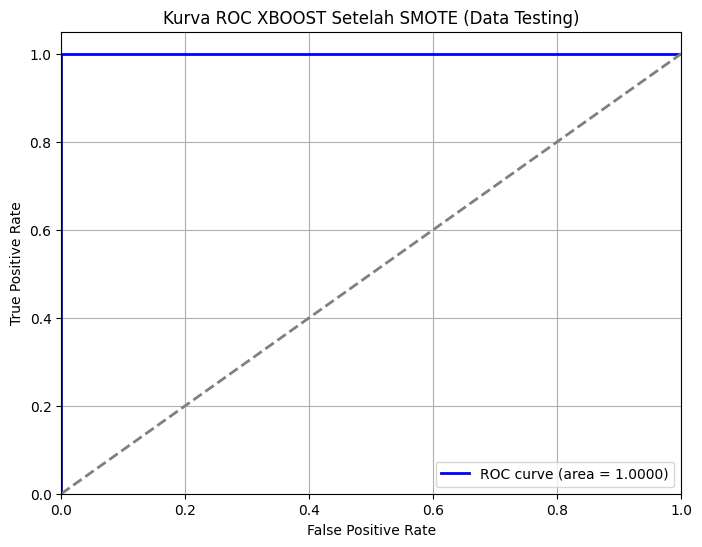

In [228]:
# Melatih model XGBoost dengan data SMOTE
xgb_model_smote = XGBClassifier(random_state=1234) 
xgb_model_smote.fit(x_smote_xgb, y_smote)

# Melakukan prediksi
y_pred_xgb_smote = xgb_model_smote.predict(x_test_xgb)

# Evaluasi model XGBoost
print("Confusion Matrix XGBoost:")
cm_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote)

accuracy_xgb_smote = accuracy_score(y_test, y_pred_xgb_smote)
sensitivity_xgb_smote = recall_score(y_test, y_pred_xgb_smote)
specificity_xgb_smote = cm_xgb_smote[0, 0] / (cm_xgb_smote[0, 0] + cm_xgb_smote[0, 1])

print("Confusion Matrix:")
print(cm_xgb_smote)
print(f"Accuracy: {accuracy_xgb_smote:.4f}")
print(f"Sensitivity (Recall): {sensitivity_xgb_smote:.4f}")
print(f"Specificity: {specificity_xgb_smote:.4f}")
# Hitung ROC AUC Score XGBoost
y_pred_proba_xgb_smote = xgb_model_smote.predict_proba(x_test_xgb)[:, 1]
roc_auc_xgb_smote = roc_auc_score(y_test, y_pred_proba_xgb_smote)
print("ROC AUC Score XGBoost: {:.4f}".format(roc_auc_xgb_smote))

# Plot ROC curve
fpr_xgb_smote, tpr_xgb_smote, thresholds_xgb_smote = roc_curve(y_test, y_pred_proba_xgb_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, color='blue', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc_xgb_smote))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC XBOOST Setelah SMOTE (Data Testing)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Confusion Matrix XGBoost:
Confusion Matrix:
[[49  0]
 [ 0 17]]
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
ROC AUC Score XGBoost: 1.0000


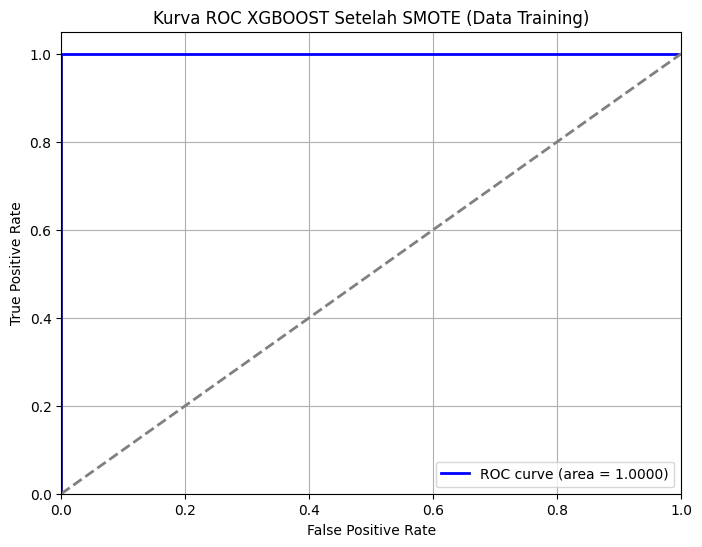

In [229]:
# Melakukan prediksi
y_pred_xgb_smote_train = xgb_model_smote.predict(x_train_xgb)

# Evaluasi model XGBoost
print("Confusion Matrix XGBoost:")
cm_xgb_smote_train = confusion_matrix(y_train, y_pred_xgb_smote_train)

accuracy_xgb_smote_train = accuracy_score(y_train, y_pred_xgb_smote_train)
sensitivity_xgb_smote_train = recall_score(y_train, y_pred_xgb_smote_train)
specificity_xgb_smote_train = cm_xgb_smote_train[0, 0] / (cm_xgb_smote_train[0, 0] + cm_xgb_smote_train[0, 1])

print("Confusion Matrix:")
print(cm_xgb_smote_train)
print(f"Accuracy: {accuracy_xgb_smote_train:.4f}")
print(f"Sensitivity (Recall): {sensitivity_xgb_smote_train:.4f}")
print(f"Specificity: {specificity_xgb_smote_train:.4f}")
# Hitung ROC AUC Score XGBoost
y_pred_proba_xgb_smote_train = xgb_model_smote.predict_proba(x_train_xgb)[:, 1]
roc_auc_xgb_smote_train = roc_auc_score(y_train, y_pred_proba_xgb_smote_train)
print("ROC AUC Score XGBoost: {:.4f}".format(roc_auc_xgb_smote_train))

# Plot ROC curve
fpr_xgb_smote_train, tpr_xgb_smote_train, thresholds_xgb_smote_train = roc_curve(y_train, y_pred_proba_xgb_smote_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_smote_train, tpr_xgb_smote_train, color='blue', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc_xgb_smote_train))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC XGBOOST Setelah SMOTE (Data Training)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [230]:
# Simpan model XGBoost ke file
joblib.dump(xgb_model_smote, "best_model.pkl")

['best_model.pkl']

## Variable Importance

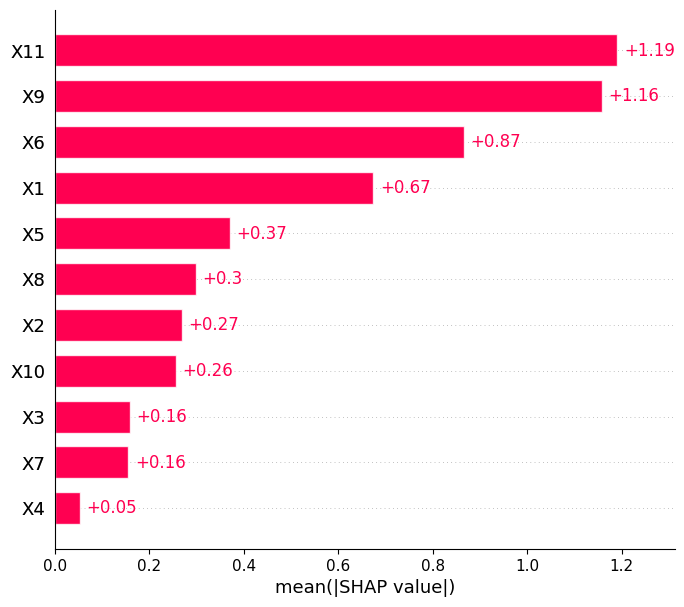

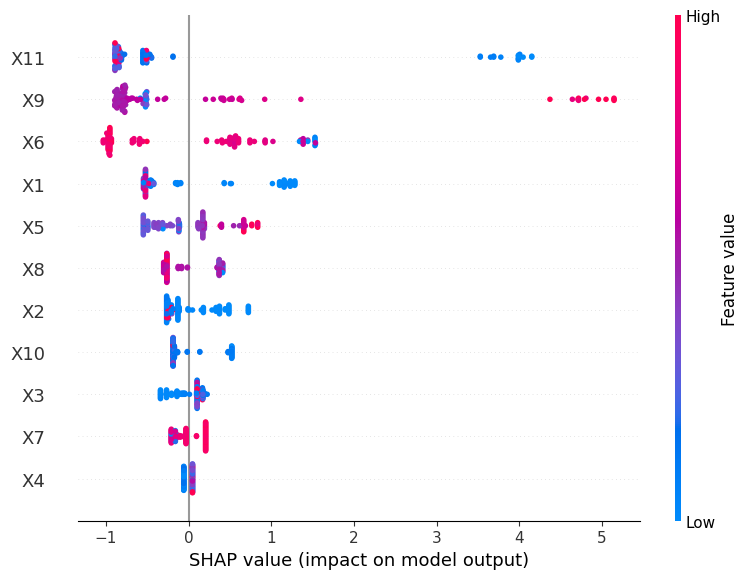

In [240]:
data_shap = pd.DataFrame(data)
shap_df = shap.maskers.Independent(data_shap.drop(['Y','A','B','C','t'], axis=1))
explainer = shap.Explainer(xgb_model_smote, shap_df)
shap_values = explainer(data.drop(['Y','A','B','C','t'], axis=1))
shap.plots.bar(shap_values, max_display=13)
shap.summary_plot(shap_values.values, data.drop(['Y', 'A', 'B', 'C', 't'], axis=1))

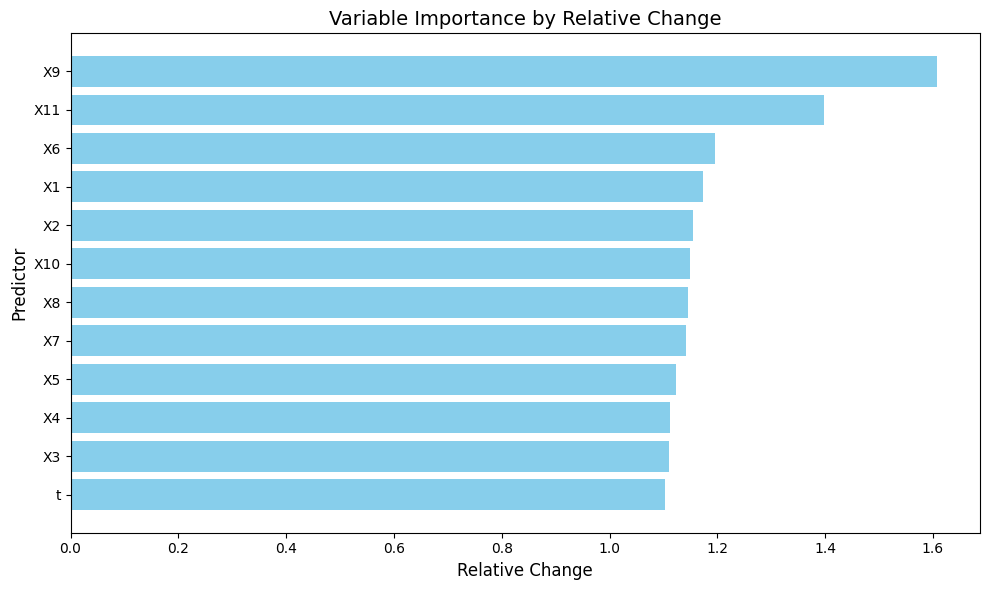

In [28]:
# Ekstrak variable importance dari model R
varimp = robjects.r('varimp_hrf(model_smote_hrf)')

# Konversi hasil R ke Pandas DataFrame
# Pastikan format kolom sesuai: Predictor, Marginalized error, Model error, Relative change, Z-value
data = {
    "Predictor": list(varimp[0]),
    "Marginalized error": list(varimp[1]),
    "Model error": list(varimp[2]),
    "Relative change": list(varimp[3]),
    "Z-value": list(varimp[4]),
}
df = pd.DataFrame(data)

# Hapus variabel 'Y' dan 't'
df = df[~df["Predictor"].isin(["Y"])]

# Urutkan berdasarkan Relative Change
df = df.sort_values(by="Relative change", ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.barh(df["Predictor"], df["Relative change"], color="skyblue")
plt.xlabel("Relative Change", fontsize=12)
plt.ylabel("Predictor", fontsize=12)
plt.title("Variable Importance by Relative Change", fontsize=14)
plt.gca().invert_yaxis()  # Membalik urutan agar yang terbesar di atas
plt.tight_layout()
plt.show()